In [1]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# rotation object can be defined from vec, quat, matrix
r = R.from_rotvec(np.pi/2 * np.array([0, 0, 1]))
r = R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)])
r = R.from_matrix([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

# rotation object can be converted to vec, quat, matrix
r.as_rotvec()
r.as_quat()
r.as_euler('zyx', degrees=True)

# possible to invert rotation
r1 = R.from_euler('z', [90, 45], degrees=True)
r2 = r1.inv()
r2.as_euler('zyx', degrees=True)


array([[-90.,   0.,  -0.],
       [-45.,   0.,  -0.]])

# Rotation Plot Example

In [52]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import numpy as np


def plot_rotated_axes(ax, r, name=None, offset=(0, 0, 0), scale=1):
    colors = ("#FF6666", "#005533", "#1199EE")  # Colorblind-safe RGB
    origins = np.array([offset, offset])
    
    for i, (axis, c) in enumerate(zip((ax.xaxis, ax.yaxis, ax.zaxis), colors)):
        axlabel = axis.axis_name
        axis.set_label_text(axlabel)
        axis.label.set_color(c)
        axis.line.set_color(c)
        axis.set_tick_params(colors=c)
        
        axisline = np.zeros((2, 3))
        axisline[1, i] = 1
        axisline_rot = r.apply(axisline) #rot is applied only on 2nd row element
        axisline_startend = axisline_rot + origins[0] #[[],[]]
        
        ax.plot(axisline_startend[:, 0], axisline_startend[:, 1], axisline_startend[:, 2], c)
        text_loc = axisline[1]*1.2
        text_loc_rot = r.apply(text_loc)
        text_plot = text_loc_rot + origins[0]
        
        ax.text(*text_plot, axlabel.upper(), color=c,
                va="center", ha="center")
    ax.text(*offset, name, color="k", va="center", ha="center",
            bbox={"fc": "w", "alpha": 0.8, "boxstyle": "circle"})

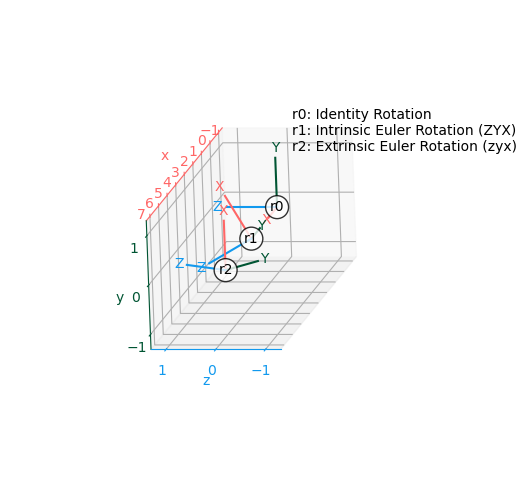

In [73]:
r0 = R.identity()
r1 = R.from_euler("ZYX", [90, -30, 0], degrees=True)  # intrinsic
r2 = R.from_euler("zyx", [90, -30, 0], degrees=True)  # extrinsic

ax = plt.figure().add_subplot(projection="3d", proj_type="ortho")
plot_rotated_axes(ax, r0, name="r0", offset=(0, 0, 0))
plot_rotated_axes(ax, r1, name="r1", offset=(3, 0, 0))
plot_rotated_axes(ax, r2, name="r2", offset=(6, 0, 0))
_ = ax.annotate(
    "r0: Identity Rotation\n"
    "r1: Intrinsic Euler Rotation (ZYX)\n"
    "r2: Extrinsic Euler Rotation (zyx)",
    xy=(0.6, 0.7), xycoords="axes fraction", ha="left"
)
ax.view_init(elev=-10, azim=12, roll=90)
ax.set(xlim=(-1.25, 7.25), ylim=(-1.25, 1.25), zlim=(-1.25, 1.25))
ax.set(xticks=range(-1, 8), yticks=[-1, 0, 1], zticks=[-1, 0, 1])
ax.set_aspect("equal", adjustable="box")
ax.figure.set_size_inches(6, 5)
plt.tight_layout()
plt.show()

## rotation and Position of HMD & HMD w.r.t HMD1

In [2]:
import os, csv, pickle, gzip, torch
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R


def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output

#=======================================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z

spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
print(dffile.head)

file_name = "0814-f18"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

open gzip


In [20]:
dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
# print(dffile.head)
dffile = dffile[['sub_idx','file_idx','length', 'h','v','d']]
params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])

In [98]:
%matplotlib notebook
%matplotlib inline
from tqdm import tqdm
from functools import partial
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import rc
import matplotlib.cm as cm
from matplotlib.collections import LineCollection

# 1. read tensors (Y, hmd, hmd1, params)
# 2. input sIdx fIdx and draw
# 3. drawing animation
# 4. getting pos and rotation tensor for all frames in file

def read_tensors(ffile):
    list_y = []
    list_hmd = []
    list_hmd1 = []
    list_eye = []
    list_eye1 = []
    for sIdx in range(24):
        _,trimY,_,_, trimHmd,trimHmd1,trimEye,trimEye1,_ = ffile[sIdx]    
        list_y.append(trimY)
        list_hmd.append(trimHmd)
        list_hmd1.append(trimHmd1)
        list_eye.append(trimEye)
        list_eye1.append(trimEye1)
    return list_y, list_hmd, list_hmd1, list_eye, list_eye1

Y, HMD, HMD1, EYE, EYE1 = read_tensors(ffile)

def animate_transforms(input_tensor, name):
    """
    func: draw transform animation from file tensor
    input: input_tensor=[f,4,4]
    """    
    # --- DownSample Tensor by 10 ---
    input_tensor = input_tensor[::10]
    
    
    # --- DEFINE PLOT ---
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111, projection='3d')  
    plt.title(name)
    # ax.view_init(azim=-90, elev=180)
    ax.view_init(elev=-10, azim=12, roll=90)
    ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_zlabel('z')
    ax.set_xlim(-4, 4), ax.set_ylim(-4.1, 4.1), ax.set_zlim(-1.1, 4,1)
    ax.set(xticks=range(-1, 8), yticks=[-1, 0, 1], zticks=[-1, 0, 1])
    ax.set_aspect("equal", adjustable="box")
    fig.tight_layout()
 
    # --- FUNCANIM VARIABLES ---
    length = input_tensor.shape[0]
    print(length)
    zeros = (0,0,0)    
    update.txt = ax.text(*zeros, "kkk")
    update.txt_axis = []
    update.txt_axis.append( ax.text(*zeros, "kkk"))#x
    update.txt_axis.append( ax.text(*zeros, "kkk"))#y
    update.txt_axis.append( ax.text(*zeros, "kkk"))#z
    update.pl  = []
    data = np.zeros((3,2))
    update.lines = []
    update.lines.append( ax.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1]) ) #xline
    update.lines.append( ax.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1]) ) #yline
    update.lines.append( ax.plot(data[0, 0:1], data[1, 0:1], data[2, 0:1]) ) #zline
        
    # --- FUNCANIM ---
    anim = FuncAnimation(fig, partial(update, tensor=input_tensor, ax=ax),  frames=range(length), interval=8.3*4, blit=False)
    
    # --- CLOSE AND RETURN ---
    plt.close()    
    return anim


def update(frame, tensor, ax):

    colors = ("#FF6666", "#005533", "#1199EE")  # Colorblind-safe RGB
    scale = 1
    t= tensor[frame]
    r = R.from_matrix(t[:3,:3])
    p = t[:3, 3].tolist()
    origins = np.array([p, p])
    
    update.txt.remove()
    p_2f = list(np.around(np.array(p),2))
    # p_2f_precision = ['%.2f' % elem for elem in p]
    update.txt = ax.text(*p, str(p_2f))  
    
    axis_name = ['z', 'x', 'y']
    for i, (axis, c) in enumerate(zip((ax.xaxis, ax.yaxis, ax.zaxis), colors)):
        # axlabel = axis_name[i]
        axlabel = axis.axis_name
        axis.set_label_text(axlabel)
        axis.label.set_color(c)
        axis.line.set_color(c)
        axis.set_tick_params(colors=c)
        axisline = np.zeros((2, 3))
        axisline[1, i] = 1
        axisline_rot = r.apply(axisline) #rot is applied only on 2nd row element
        axisline_startend = axisline_rot + origins[0] #[[],[]]
        
        text_loc = axisline[1]*1.2
        text_loc_rot = r.apply(text_loc)
        text_plot = text_loc_rot + origins[0]        
        
        
        update.lines[i][0].set_xdata(axisline_startend[:, 0])
        update.lines[i][0].set_ydata(axisline_startend[:, 1])
        update.lines[i][0].set_3d_properties(axisline_startend[:, 2])
        
        update.txt_axis[i].remove()
        update.txt_axis[i]=(ax.text(*text_plot, axlabel.upper(), color=c,
                va="center", ha="center")        )

In [102]:
# --- SET Subject and file ---
sIdx = int(input("sIdx to draw hmd: "))
fIdx = int(input("fIdx to draw hmd rot: "))
params = Y[sIdx][fIdx] #[azimuth, elevation, distance) w.r.t hmd1
print(params.shape)


# --- CALC gtpos w.r.t hmd ---
hmd_gt_tensors = []
for f, param in enumerate(params):
    h, v, d = param[0], param[1], param[2]
    H = h * torch.pi / 180
    V = v * torch.pi / 180
    x = -(d) * torch.sin(H) * torch.cos(V)
    y = (d) * torch.cos(H) * torch.sin(V)   
    z = (d) * torch.cos(H) * torch.cos(V)         
    t = torch.eye(4, dtype=torch.float32)
    t[:3, 3] = torch.tensor([x,y,z], dtype=torch.float32)
    hmd_gt_tensors.append(t)
hmd_gt_tensors = torch.stack(hmd_gt_tensors)
print(hmd_gt_tensors.shape)

# --- ANIMATE transforms for file (downsample =10) ---
name1 = 'gt w.r.t hmd: sIdx: (' + str(sIdx) + "/23) (fidx: " + str(fIdx) + "/143)"
anim1= animate_transforms(hmd_gt_tensors, name1)
rc('animation', html='html5')
anim1

sIdx to draw hmd:  1
fIdx to draw hmd rot:  0


torch.Size([667, 3])
torch.Size([667, 4, 4])
67


C:\Users\thecascade-pc1\AppData\Local\Temp\ipykernel_23392\2353756420.py:51: MatplotlibDeprecationWarning: Passing the emit parameter of set_zlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_xlim(-4, 4), ax.set_ylim(-4.1, 4.1), ax.set_zlim(-1.1, 4,1)


In [76]:
# --- SET Subject and file ---
sIdx = int(input("sIdx to draw hmd: "))
fIdx = int(input("fIdx to draw hmd rot: "))
hmd = HMD[sIdx][fIdx]
hmd1 = HMD1[sIdx][fIdx]

# --- CALC hmd transform w.r.t hmd1 ---
abs_hmd_tensors = []
for f, (h, h1) in enumerate(zip(hmd, hmd1)):
    abs_h = torch.matmul(torch.linalg.inv(h1), h)
    # abs_hmd_tensors.append(abs_h)
    abs_hmd_tensors.append(h)
abs_hmd_tensors = torch.stack(abs_hmd_tensors)
print(abs_hmd_tensors.shape)

# --- ANIMATE transforms for file (downsample =10) ---
name1 = 'hmd: sIdx: (' + str(sIdx) + "/23) (fidx: " + str(fIdx) + "/143)"
anim1= animate_transforms(abs_hmd_tensors, name1)
rc('animation', html='html5')
anim1

sIdx to draw hmd:  1
fIdx to draw hmd rot:  0


torch.Size([667, 4, 4])
67


C:\Users\thecascade-pc1\AppData\Local\Temp\ipykernel_23392\2586455030.py:53: MatplotlibDeprecationWarning: Passing the emit parameter of set_zlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_xlim(-4, 4), ax.set_ylim(-4.1, 4.1), ax.set_zlim(-1.1, 4,1)


In [90]:
# --- SET Subject and file ---
sIdx = int(input("sIdx to draw hmd: "))
fIdx = int(input("fIdx to draw hmd rot: "))
eIdx = int(input("0:combined,1:left_eye,2:right_eye: "))
hmd = HMD[sIdx][fIdx]
hmd1 = HMD1[sIdx][fIdx]
eye = EYE[sIdx][fIdx][:,eIdx] # (comb, left, right) eye
eye1 = EYE1[sIdx][fIdx][:,eIdx] #needed if we are trying to plot only eye movement. Not used for projection w.r.t HMD1
print(eye.shape)
param = PARAMS[sIdx][fIdx]

# --- CALC HRC w.r.t hmd1 ---
erc_proj_tensors = []
azimuth, elevation, distance = param
for f, (t_h, t_h1, t_he, t_he1) in enumerate(zip(hmd, hmd1, eye, eye1)):    
    t_h1h = torch.matmul(torch.linalg.inv(t_h1), t_h)
    t_h1e = torch.matmul(t_h1h, t_he)
    
    d1 = torch.norm(t_h1h[:3,3])
    d2 = torch.sqrt(distance*distance - d1*d1)
    d3 = torch.norm(t_he[:3,3])
    d4 = torch.sqrt(d2*d2 - d3*d3)
    
    t_ed4 = torch.eye(4,4)
    t_ed4[2,3] = d4
    t_h1d4 = torch.matmul(t_h1e, t_ed4)
    erc_proj_tensors.append(t_h1d4)
erc_proj_tensors = torch.stack(erc_proj_tensors)



# --- ANIMATE transforms for file (downsample =10) ---
name1 = 'ERC: sIdx: (' + str(sIdx) + "/23) (fidx: " + str(fIdx) + "/143)"
anim1= animate_transforms(erc_proj_tensors, name1)
# anim1= animate_transforms(abs_hmd_tensors, name1)
rc('animation', html='html5')
anim1

sIdx to draw hmd:  1
fIdx to draw hmd rot:  0
0:combined,1:left_eye,2:right_eye:  0


torch.Size([667, 4, 4])
67


C:\Users\thecascade-pc1\AppData\Local\Temp\ipykernel_23392\2353756420.py:51: MatplotlibDeprecationWarning: Passing the emit parameter of set_zlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_xlim(-4, 4), ax.set_ylim(-4.1, 4.1), ax.set_zlim(-1.1, 4,1)


In [ ]:
# --- SET Subject and file ---
sIdx = int(input("sIdx to draw hmd: "))
fIdx = int(input("fIdx to draw hmd rot: "))
hmd = HMD[sIdx][fIdx]
hmd1 = HMD1[sIdx][fIdx]
param = PARAMS[sIdx][fIdx]

# --- CALC HRC w.r.t hmd1 ---
hrc_proj_tensors = []
# hrc_proj_pos = []
azimuth, elevation, distance = param
for f, (t_h, t_h1) in enumerate(zip(hmd, hmd1)):    
    t_h1h = torch.matmul(torch.linalg.inv(t_h1), t_h)
    d1 = torch.norm(t_h1h[:3,3])
    d2 = torch.sqrt(distance*distance - d1*d1)
    t_hd2 = torch.eye(4,4)
    t_hd2[2,3] = d2
    t_h1d2 = torch.matmul(t_h1h, t_hd2)
    hrc_proj_tensors.append(t_h1d2)
hrc_proj_tensors = torch.stack(hrc_proj_tensors)



# --- ANIMATE transforms for file (downsample =10) ---
name1 = 'HRC: sIdx: (' + str(sIdx) + "/23) (fidx: " + str(fIdx) + "/143)"
anim1= animate_transforms(hrc_proj_tensors, name1)
# anim1= animate_transforms(abs_hmd_tensors, name1)
rc('animation', html='html5')
anim1

### 2차원 Lineplot이나 axvline의 경우에는 각각 reset을 하거나 remove를 해야 한다. 

In [1]:
# https://stackoverflow.com/questions/43445103/inline-animations-in-jupyter
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib import rc
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot(t[0],x[0])

def init():
    l, = ax.plot(t[0],x[0])
    return l

def animate(i):
    l.set_data(t[i-2:i], x[i-2:i])
    coords = (2, 0.01*i)
    animate.txt.remove()
    animate.txt = ax.text(*coords,"hi")

origin=(0,0)
animate.txt = ax.text(*origin,"hi")    
anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
plt.close()


# --- Embed as video in Juypyter notebook---
rc('animation', html='html5')
anim

# --- Show in Jupyter notebook with interaction ---
# from IPython.display import HTML
# HTML(ani.to_jshtml())

In [33]:
print(torch.eye(4,4))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
